In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

 99% 1.61G/1.62G [00:54<00:00, 40.4MB/s]
100% 1.62G/1.62G [00:54<00:00, 32.0MB/s]


In [6]:
! mkdir ocular-disease

In [ ]:
! unzip ocular-disease-recognition-odir5k.zip -d ocular-disease

In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from skimage import color
from skimage import io

In [83]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tqdm import trange, tqdm
import os
import random
import cv2
dataset_dir = "/content/ocular-disease/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        #print(image_path)
        try:
            #image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.imread(image_path)
            image = cv2.resize(image,(image_size,image_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #image = color.rgb2gray(image)
            #print(image)
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [9]:
df = pd.read_csv('/content/ocular-disease/full_df.csv')

In [109]:
df_gl=df.copy()

In [11]:
def has_dr(text):
    if "glauc" in text:
        return 1
    else:
        return 0

In [12]:
df_gl["left_glau"] = df_gl["Left-Diagnostic Keywords"].apply(lambda x: has_dr(x))
df_gl["right_glau"] = df_gl["Right-Diagnostic Keywords"].apply(lambda x: has_dr(x))

In [41]:
left_glau = df_gl.loc[(df_gl.G ==1) & (df_gl.left_glau == 1)]["Left-Fundus"].values
right_glau = df_gl.loc[(df_gl.G ==1) & (df_gl.right_glau == 1)]["Right-Fundus"].values

In [42]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

In [36]:
left_glau.shape
right_glau.shape

(284,)

In [43]:
import numpy as np
glau = np.concatenate((left_glau,right_glau),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
plt.imshow(image)

In [52]:
print(glau.shape)
print(normal.shape)

(616,)
(500,)


In [84]:
datasetGL.clear()

In [85]:
datasetGL=create_dataset(glau,1)

100%|██████████| 616/616 [00:03<00:00, 197.72it/s]


In [86]:
len(datasetGL)

613

In [87]:
datasetGL = create_dataset(normal,0)

100%|██████████| 500/500 [00:02<00:00, 193.03it/s]


In [110]:
len(datasetGL)

1113

In [89]:
datasetGL[0][0].shape

(224, 224)

In [74]:
image = color.rgb2gray(datasetGL[0][0])
image.shape

(224, 224)

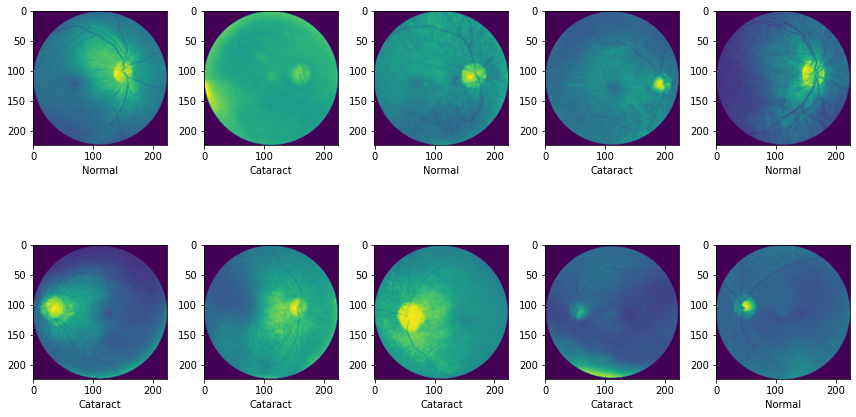

In [90]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(datasetGL)))
    image = datasetGL[sample][0]
    category = datasetGL[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

In [93]:
x = np.array([i[0] for i in datasetGL]).reshape(-1,image_size,image_size)
y = np.array([i[1] for i in datasetGL])

In [94]:
print(x.shape)
print(y.shape)

(1113, 224, 224)
(1113,)


In [112]:
x = x.reshape((len(y), -1))

print(x.shape)

(1113, 50176)


In [113]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [114]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(890, 50176) (890,)
(223, 50176) (223,)


#Training

In [99]:
from sklearn import svm, metrics

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

In [116]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

In [117]:
classifier.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [119]:
# Now predict the value of test data:
expected = y_test
predicted = classifier.predict(x_test)

In [120]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        99
           1       1.00      0.80      0.89       124

    accuracy                           0.89       223
   macro avg       0.90      0.90      0.89       223
weighted avg       0.91      0.89      0.89       223


Confusion matrix:
[[99  0]
 [25 99]]


In [121]:
knn = KNeighborsClassifier(5)

In [122]:
knn.fit(x_train,y_train)

# Now predict the value of the digit on the second half:
expected = y_test
predicted = knn.predict(x_test)

In [123]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.64      0.57      0.60        99
           1       0.68      0.74      0.71       124

    accuracy                           0.66       223
   macro avg       0.66      0.65      0.65       223
weighted avg       0.66      0.66      0.66       223


Confusion matrix:
[[56 43]
 [32 92]]


In [124]:
rfc = RandomForestClassifier()

In [125]:
classifier.fit(x_train,y_train)

# Now predict the value of the digit on the second half:
expected = y_test
predicted = classifier.predict(x_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        99
           1       1.00      0.80      0.89       124

    accuracy                           0.89       223
   macro avg       0.90      0.90      0.89       223
weighted avg       0.91      0.89      0.89       223


Confusion matrix:
[[99  0]
 [25 99]]
